In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.interpolate import splrep, BSpline
import pickle

from src.preprocess import stratify5
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2
from src.smoothing import apply_pspline_smoothing, expand_coefficients

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# 1 - Prepare Data

In [14]:
#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data2.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/1668579925.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


In [15]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - P-SPLINE SMOOTHING

## lambda = 1

In [16]:
lambda_penalty = 1.0

# Apply P-spline smoothing
smoothed_lrtt_train, coefficients_lrtt_train = apply_pspline_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', 14, lambda_penalty)
smoothed_maf12c_train, coefficients_maf12c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_train, coefficients_maf3c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 6, lambda_penalty)

smoothed_lrtt_test, coefficients_lrtt_test = apply_pspline_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', 14, lambda_penalty)
smoothed_maf12c_test, coefficients_maf12c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_test, coefficients_maf3c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 6, lambda_penalty)

# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/998623509.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/998623509.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_maf['smoothed_maf12c'] = smoothed_maf12c_train
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/998623509.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

# Plot - Averaged

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/2889959875.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96282/2889959875.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


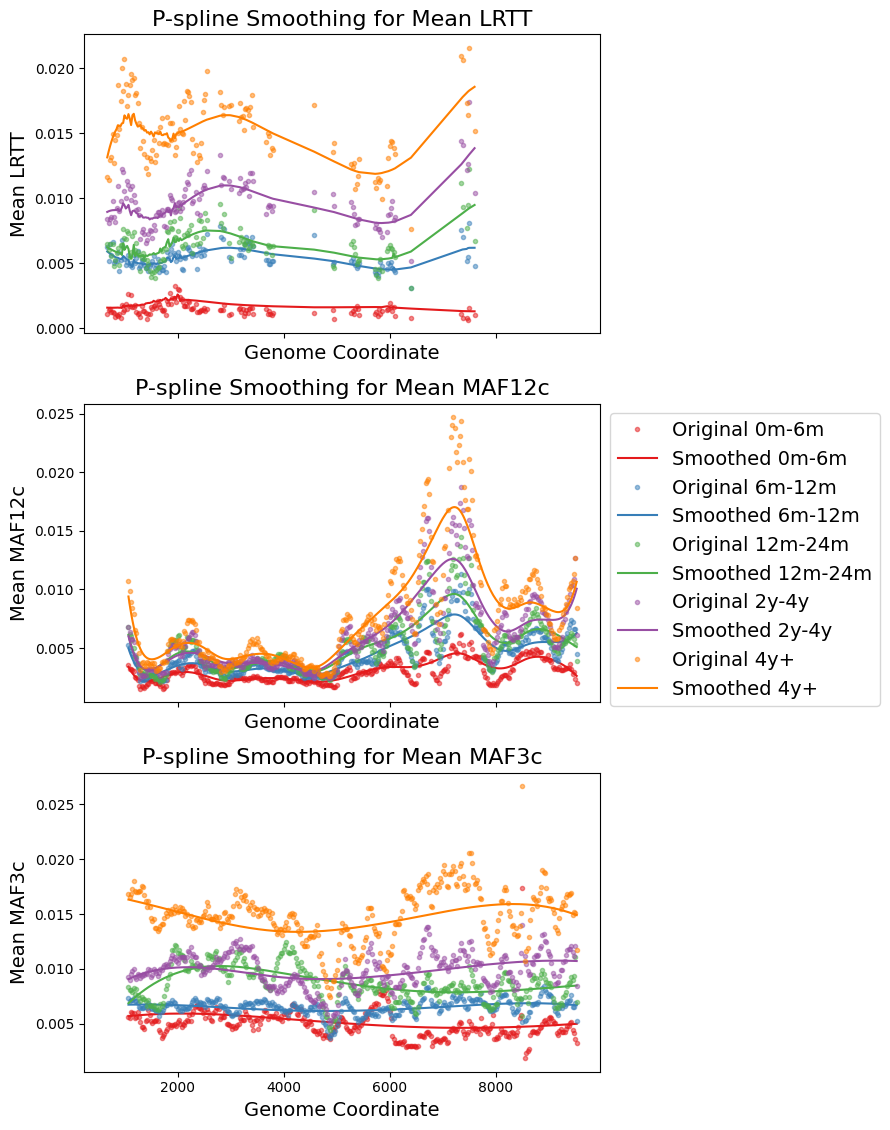

In [18]:
#Aggregate by Class and Genome coordinate
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()
mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for LRTT
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('Genome Coordinate', size = 14)
axs[0].set_ylabel('Mean LRTT', size = 14)
axs[0].set_title('P-spline Smoothing for Mean LRTT', size = 16)

# Plot for MAF12c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Genome Coordinate', size = 14)
axs[1].set_ylabel('Mean MAF12c', size = 14)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
axs[1].set_title('P-spline Smoothing for Mean MAF12c', size = 16)

# Plot for MAF3c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Genome Coordinate', size = 14)
axs[2].set_ylabel('Mean MAF3c', size = 14)
axs[2].set_title('P-spline Smoothing for Mean MAF3c', size = 16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./outputs/smoothing/average_pspline_vertical.pdf')
plt.show()

# Plot - Sampled Individuals

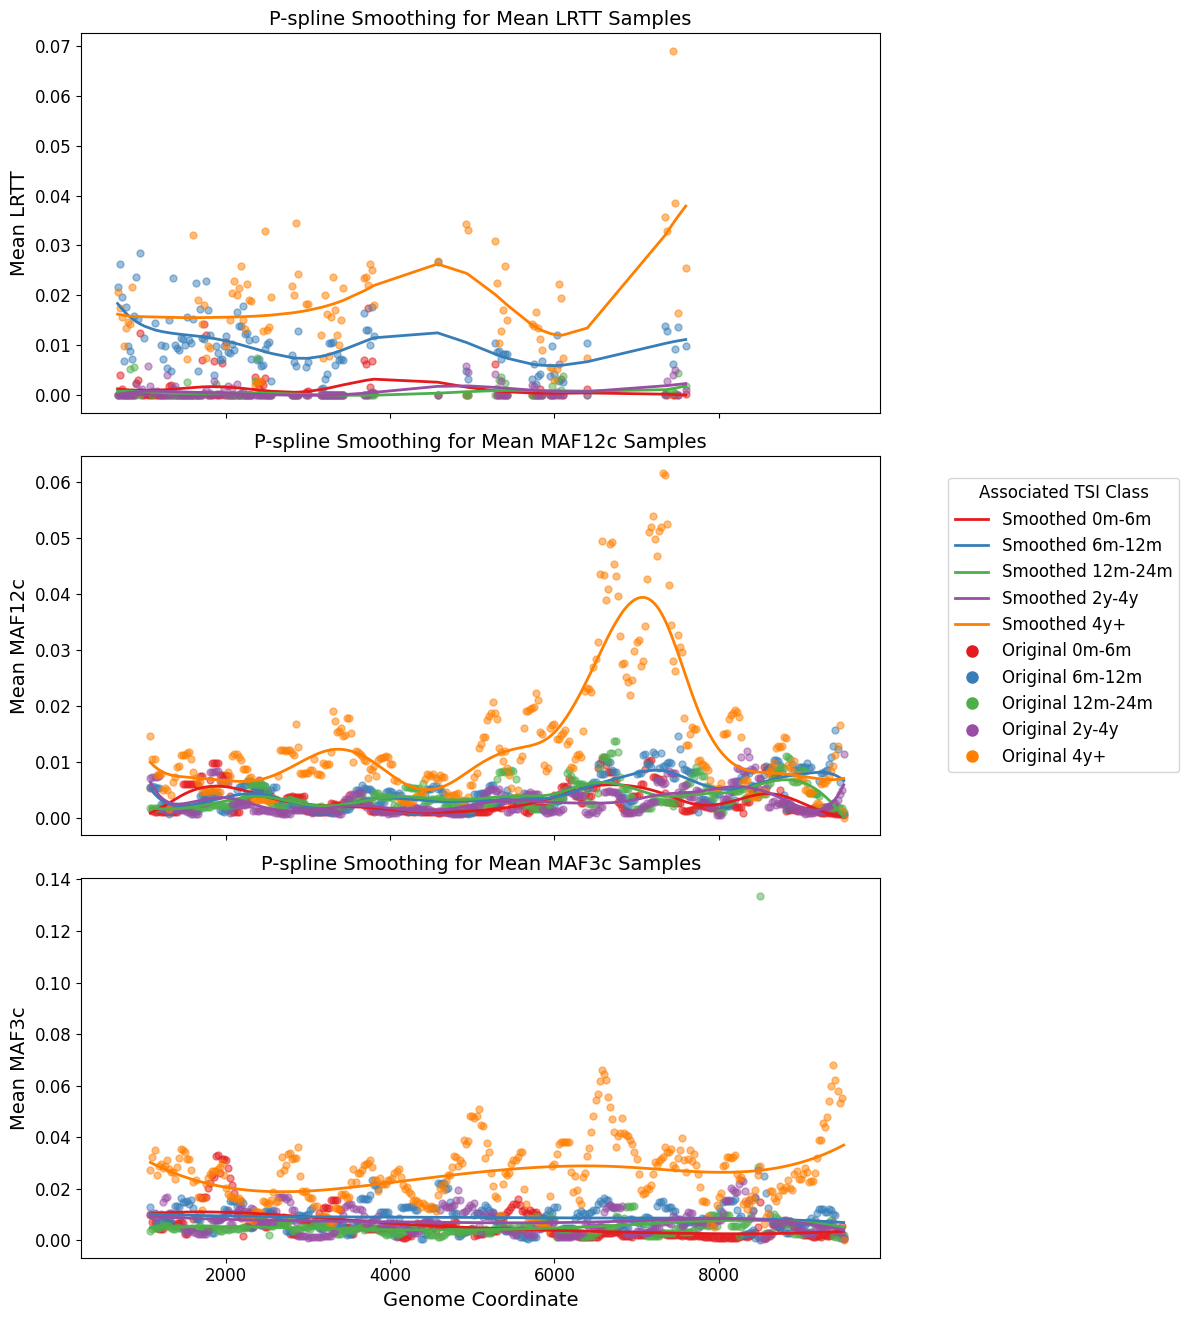

In [29]:
#extract sample ids to be consistent with bspline plot
with open('./outputs/smoothing/sampled_ids_by_class.pkl', 'rb') as f:
    sampled_ids_by_class = pickle.load(f)

fig, axs = plt.subplots(3, 1, figsize=(9, 14), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for LRTT
for i, category in enumerate(mean_values['TSI_category'].unique()):
    sampled_ids = sampled_ids_by_class.get(category, [])
    
    # Plot each sampled RENAME_ID
    for rename_id in sampled_ids:
        sample_df = train_phylo[train_phylo['RENAME_ID'] == rename_id]
        axs[0].scatter(sample_df['xcoord'], sample_df['normalised.largest.rtt'], s=25, marker='o', color=palette[i], alpha=0.5)
        axs[0].plot(sample_df['xcoord'], sample_df['smoothed_lrtt'], '-', color=palette[i], linewidth=2)

axs[0].set_ylabel('Mean LRTT', fontsize=14)
axs[0].set_title('P-spline Smoothing for Mean LRTT Samples', fontsize=14)
axs[0].tick_params(axis='y', which='major', labelsize=12)

# Plot for MAF12c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    sampled_ids = sampled_ids_by_class.get(category, [])
    for rename_id in sampled_ids:
        sample_df = train_maf[train_maf['RENAME_ID'] == rename_id]
        axs[1].scatter(sample_df['Window_Centre'], sample_df['MAF12c_Mean'], s=25, marker='o', color=palette[i], alpha=0.5)
        axs[1].plot(sample_df['Window_Centre'], sample_df['smoothed_maf12c'], '-', color=palette[i], linewidth=2)

axs[1].set_ylabel('Mean MAF12c', fontsize=14)
axs[1].set_title('P-spline Smoothing for Mean MAF12c Samples', fontsize=14)
axs[1].tick_params(axis='y', which='major', labelsize=12)

# Plot for MAF3c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    sampled_ids = sampled_ids_by_class.get(category, [])
    
    for rename_id in sampled_ids:
        sample_df = train_maf[train_maf['RENAME_ID'] == rename_id]
        axs[2].scatter(sample_df['Window_Centre'], sample_df['MAF3c_Mean'], s=25, marker='o', color=palette[i], alpha=0.5)
        axs[2].plot(sample_df['Window_Centre'], sample_df['smoothed_maf3c'], '-', color=palette[i], linewidth=2)

axs[2].set_xlabel('Genome Coordinate', fontsize=14)
axs[2].set_ylabel('Mean MAF3c', fontsize=14)
axs[2].set_title('P-spline Smoothing for Mean MAF3c Samples', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=12)
legend_lines = [mlines.Line2D([], [], color=palette[i], linestyle='-', linewidth=2, label=f'Smoothed {category}') for i, category in enumerate(mean_values['TSI_category'].unique())]
legend_markers = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, label=f'Original {category}') for i, category in enumerate(mean_values['TSI_category'].unique())]

handles = legend_lines + legend_markers
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fontsize=12, frameon=True, title = 'Associated TSI Class', title_fontsize = 12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./outputs/smoothing/sampled_pspline_by_class.pdf', bbox_inches='tight')
plt.show()

## agreggating features

In [32]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [33]:
# Finalize the features by adding class column
train_features = stratify5(train_features)
test_features = stratify5(test_features)

## Adding Meta Features: Coefficients

In [34]:
train_features = expand_coefficients(train_features, coefficients_lrtt_train, 'lrtt')
train_features = expand_coefficients(train_features, coefficients_maf12c_train, 'maf12c')
train_features = expand_coefficients(train_features, coefficients_maf3c_train, 'maf3c')

test_features = expand_coefficients(test_features, coefficients_lrtt_test, 'lrtt')
test_features = expand_coefficients(test_features, coefficients_maf12c_test, 'maf12c')
test_features = expand_coefficients(test_features, coefficients_maf3c_test, 'maf3c')

## Add Ambiguity Data

In [35]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

In [36]:
#SAVE AS CSV FILES
train_features.to_csv('./data/derived/feature_selection/pspline_training_data.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/pspline_test_data.csv', header = True)